In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from src.options import Options

import cv2
import numpy as np
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline  

from src.data.loader_factory import load_data
from src.models.encoder import EncoderCNN
from src.models.utils import load_checkpoint

In [2]:
BEST_CHECKPOINT = '../io/models/1_run-batch_size_10/checkpoint.pth'

In [3]:
def default_image_loader(path):

    img = Image.fromarray(
        cv2.resize(np.array(Image.open(path).convert("RGB")), (224, 224))
    )
    return img

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-1.png'
sketch_fname2 = '../io/data/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-2.png'

im_pos_fname = '../io/data/raw/Sketchy/extended_photo/airplane/ext_1.jpg'
im_pos_fname2 = '../io/data/raw/Sketchy/extended_photo/airplane/ext_2.jpg'

In [6]:
sketch = transform(default_image_loader(sketch_fname))
sketch2 = transform(default_image_loader(sketch_fname2))

image_pos = transform(default_image_loader(im_pos_fname))
image_pos2 = transform(default_image_loader(im_pos_fname2))

sk_log = sketch.unsqueeze(0)
sk_log2 = sketch2.unsqueeze(0)

im_log = image_pos.unsqueeze(0)
im_log2 = image_pos2.unsqueeze(0)

sk_log = torch.cat((sk_log, sk_log2), dim=0)
im_log = torch.cat((im_log, im_log2), dim=0)

In [7]:
print('Create model')
im_net = EncoderCNN(out_size=256, attention=True)
sk_net = EncoderCNN(out_size=256, attention=True)

Create model


In [8]:
checkpoint = load_checkpoint(BEST_CHECKPOINT)
im_net.load_state_dict(checkpoint['im_state'])
sk_net.load_state_dict(checkpoint['sk_state'])

=> loading model '../io/models/1_run-batch_size_10/checkpoint.pth'
=> loaded model '../io/models/1_run-batch_size_10/checkpoint.pth' (epoch 34, map 0.2491435231081075)


<All keys matched successfully>

In [9]:
_, attn_im = im_net(im_log)
attn_im = nn.Upsample(size=(im_log[0].size(1), im_log[0].size(2)), mode='bilinear', align_corners=False)(attn_im)
attn_im = attn_im - attn_im.view((attn_im.size(0), -1)).min(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
attn_im = 1 - attn_im/attn_im.view((attn_im.size(0), -1)).max(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

In [10]:
_, attn_sk = sk_net(sk_log)
attn_sk = nn.Upsample(size=(sk_log[0].size(1), sk_log[0].size(2)), mode='bilinear', align_corners=False)(attn_sk)
attn_sk = attn_sk - attn_sk.view((attn_sk.size(0), -1)).min(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
attn_sk = attn_sk/attn_sk.view((attn_sk.size(0), -1)).max(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

In [11]:
def transpose(tensor):
    array = tensor.detach().numpy()
    return np.transpose(array, (1,2,0))

In [12]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams['axes.titlesize'] = 20

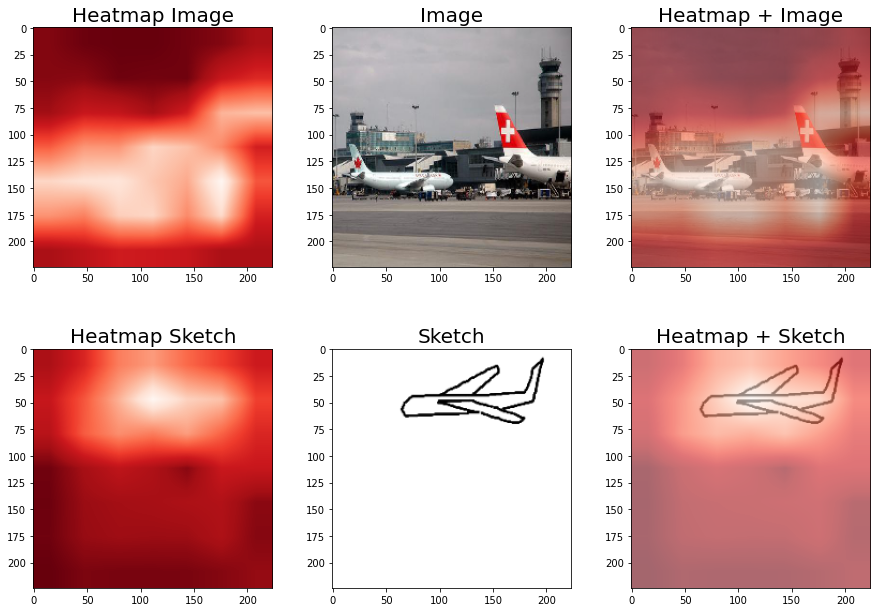

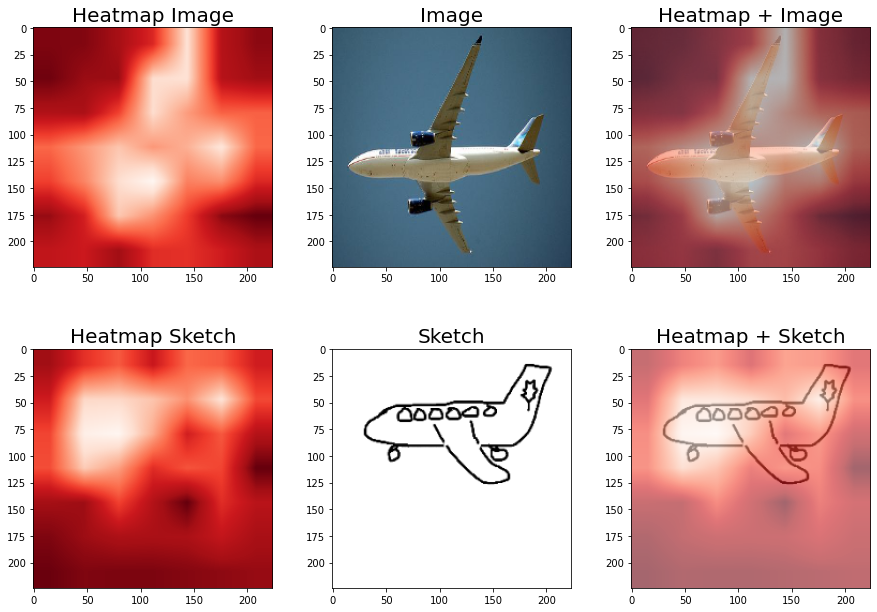

In [13]:
for i in range(im_log.size(0)): # number of images
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3) 
    
    # Heatmap Image
    heat_map_im = attn_im[i].squeeze().detach().numpy()
    heat = ax1.imshow(heat_map_im, cmap='Reds')
    ax1.set(title='Heatmap Image')
    
    # Image
    im = transpose(im_log[i])
    imval = ax2.imshow(im)
    ax2.set(title='Image')
    
    # Both: Heatmap + Image
    ax3.imshow(im)
    ax3.imshow(255 * heat_map_im, alpha=0.6, cmap='Reds')
    tot = ax3
    ax3.axis('on')
    ax3.set(title='Heatmap + Image')
    
    # Heatmap Sketch
    heat_map_sk = attn_sk[i].squeeze().detach().numpy()
    ax4.imshow(heat_map_sk, cmap='Reds')
    ax4.set(title='Heatmap Sketch')
    
    # Sketch 
    sk = transpose(sk_log[i])
    ax5.imshow(sk)
    ax5.set(title='Sketch')
    
    # Both: Heatmap + Sketch
    ax6.imshow(sk)
    ax6.imshow(255 * heat_map_sk, alpha=0.6, cmap='Reds')
    ax6.axis('on')
    ax6.set(title='Heatmap + Sketch')
    
    plt.subplots_adjust(wspace=0.25, hspace=-0.35)

    plt.show()

## Experiments

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


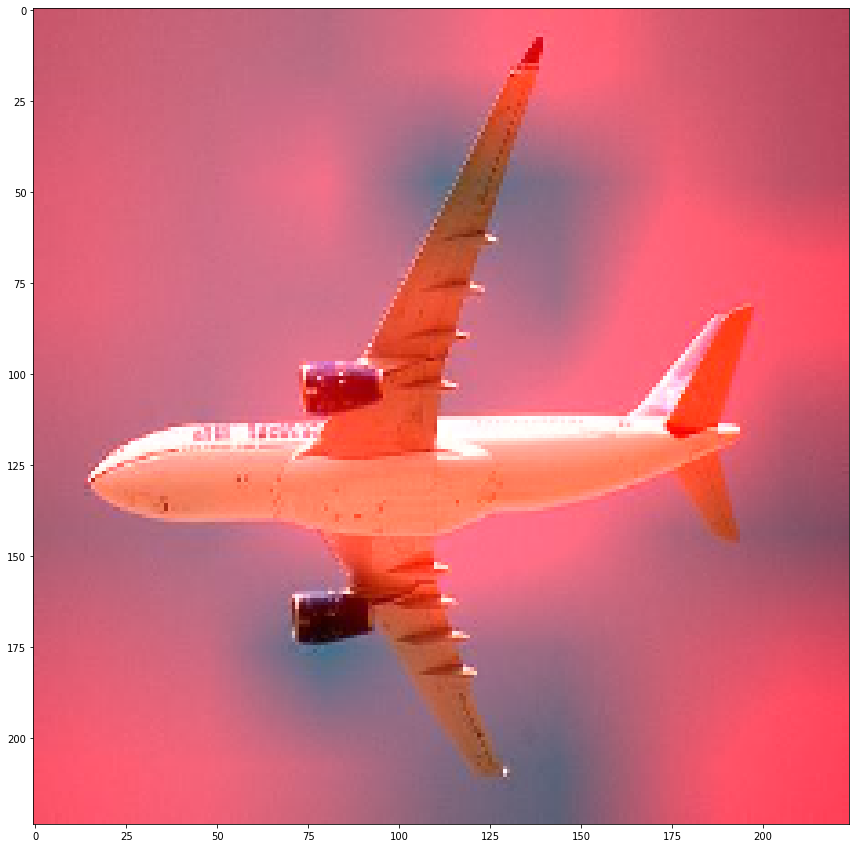

In [37]:
for i in range(im_log.size(0)): # number of images
    
    # Heatmap Image
    heat_map_im = attn_im[i].squeeze().detach().numpy()
    heatmap = plt.imshow(heat_map_im, cmap='Reds')
    heatmap = heatmap.get_array().data
    heatmap = np.expand_dims((heatmap), axis = 2)
    zeros = np.zeros_like(heatmap)
    heatmap_full = np.concatenate((heatmap, zeros, zeros), axis=2) # 3D
    
    # Image
    im = transpose(im_log[i])
    
    # Figure
    new_figure = im + heatmap_full
    plt.imshow(new_figure);

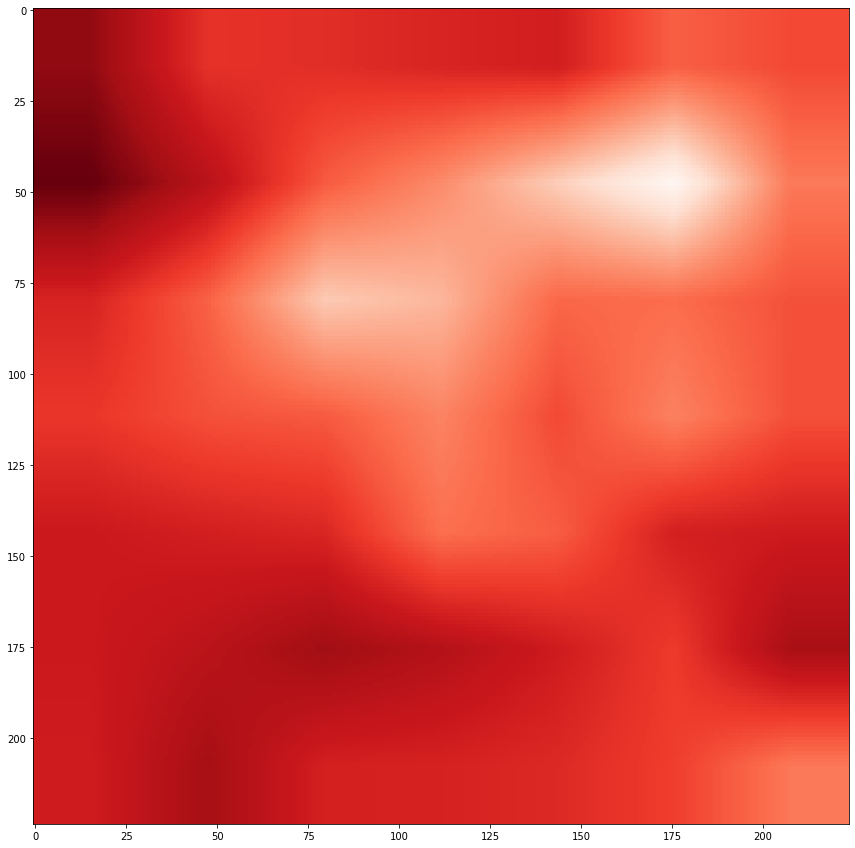

In [41]:
for i in range(im_log.size(0)): # number of images
    
    # Heatmap Image
    heat_map_im = attn_im[i].squeeze().detach().numpy()
    image_heat_map = plt.imshow(heat_map_im, cmap='Reds').get_array().data
    image_heat_map = torch.tensor(image_heat_map).unsqueeze(0)
    assert image_heat_map.shape == attn_im[i].shape
    
    # Heatmap Sketch
    heat_map_sk = attn_sk[i].squeeze().detach().numpy()
    sketch_heat_map = plt.imshow(heat_map_sk, cmap='Reds').get_array().data
    sketch_heat_map = torch.tensor(sketch_heat_map).unsqueeze(0)
    assert sketch_heat_map.shape == attn_sk[i].shape

    plt_im = torch.cat([im_log[i], image_heat_map], dim=0)
    plt_im = sk_log[i]*sketch_heat_map

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])

Image
torch.Size([4, 224, 224])

Sketch
torch.Size([3, 224, 224])


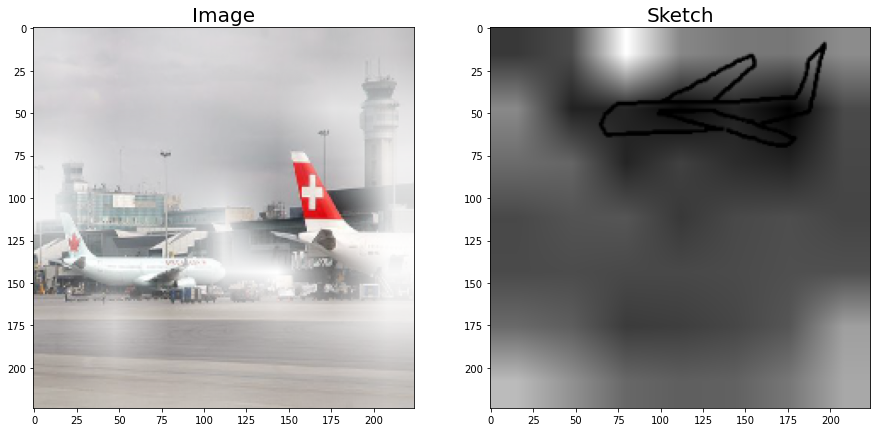

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])

Image
torch.Size([4, 224, 224])

Sketch
torch.Size([3, 224, 224])


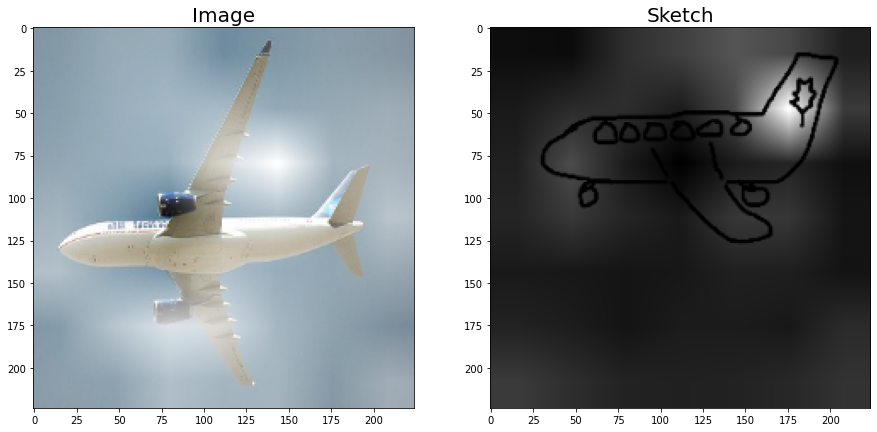

In [28]:
for i in range(im_log.size(0)):
    print(im_log[i].shape)
    print(attn_im[i].shape)
    
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    # Image
    print('\nImage')
    plt_im = torch.cat([im_log[i], attn_im[i]], dim=0)
    
    print(plt_im.shape)
    plt_im_t = transpose(plt_im)
    ax1.imshow(plt_im_t)
    ax1.set(title='Image')
    
    # Sketch
    print('\nSketch')
    plt_sk = sk_log[i]*attn_sk[i]
    
    print(plt_sk.shape)
    plt_sk_t = transpose(plt_sk)
    ax2.imshow(plt_sk_t)
    ax2.set(title='Sketch')
    
    plt.show()